## Latent PKPD Model

In [1]:
from pkpd import *
from latentINSITE import *
from utils import *

PLOT_RESULTS = False


In [2]:
# Example Parameters
population_parameters = (0.1, 0.1, 0.01)  # k_elim, k_growth, k_drug_effect
time_points = np.linspace(0, 10, 100)  # Time points for the simulation

# Latent variable polynomial coefficients (change degree as needed)
phi = [0.5, 0.2, -0.05]  # Example coefficients for Q(t) = 0.5 + 0.2*t - 0.05*t^2 (quadratic)

# Generate Data
num_individuals = 10
data = generate_baseline_pkpd_data(num_individuals, population_parameters, phi, time_points)
results_concentration_baseline, results_volume_baseline, mean_concentration, mean_volume, latent_values = data

if PLOT_RESULTS:
    # Color map for individual plots
    colors = plt.cm.viridis(np.linspace(0, 1, num_individuals))

    # Plotting the results
    plt.figure(figsize=(12, 18))

    # Plot Latent Variable Q(t)
    plt.subplot(3, 1, 1)
    plt.plot(time_points, latent_values, color='purple', linewidth=2, label='Latent Variable Q(t)')
    plt.title('Latent Variable Q(t) Over Time')
    plt.xlabel('Time')
    plt.ylabel('Q(t)')
    plt.legend()
    plt.grid()

    # Plot Drug Concentration
    plt.subplot(3, 1, 2)
    for i, concentration in enumerate(results_concentration_baseline):
        plt.plot(time_points, concentration, color=colors[i], alpha=0.7, label=f'Individual {i+1}')

    plt.plot(time_points, mean_concentration, color='red', linewidth=2, label='Population Mean Concentration')
    plt.title('PK Model: Drug Concentration Over Time')
    plt.xlabel('Time')
    plt.ylabel('Drug Concentration')
    plt.legend()
    plt.grid()

    # Plot Cancer Volume
    plt.subplot(3, 1, 3)
    for i, volume in enumerate(results_volume_baseline):
        plt.plot(time_points, volume, color=colors[i], alpha=0.7, label=f'Individual {i+1}')

    plt.plot(time_points, mean_volume, color='green', linewidth=2, label='Population Mean Volume')
    plt.title('PD Model: Cancer Volume Over Time')
    plt.xlabel('Time')
    plt.ylabel('Cancer Volume')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Fit VL-INSITE model

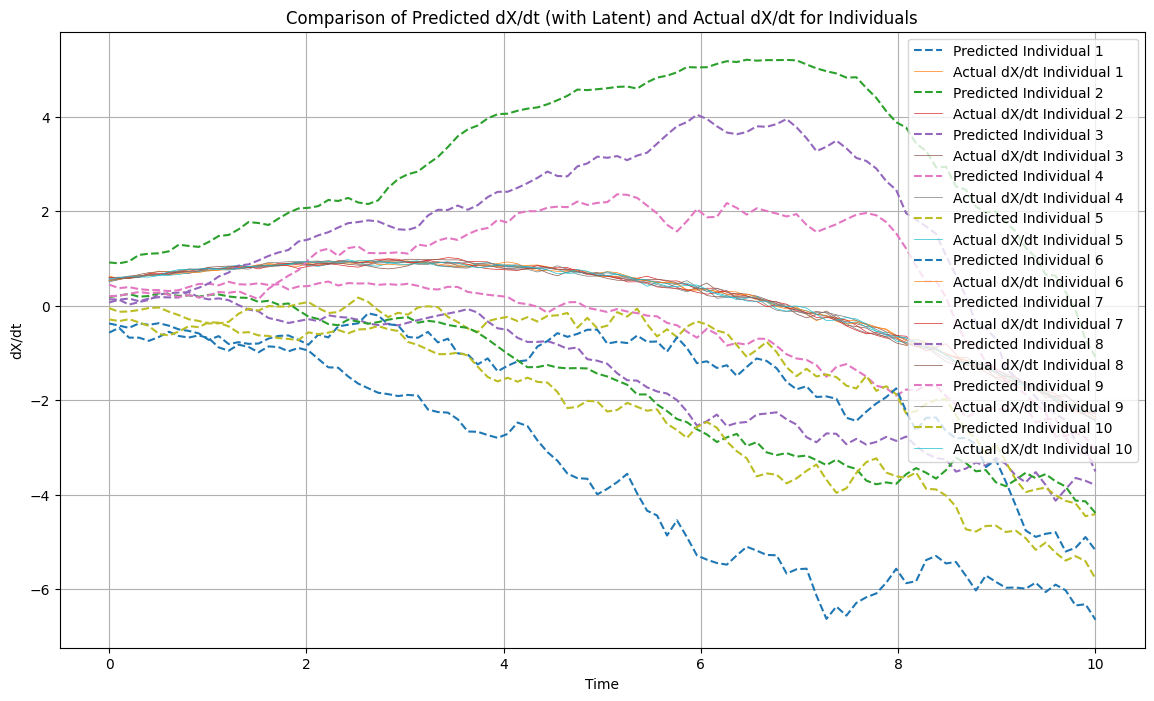

In [3]:
# Fit latent dynamics for the concentration of each individual
latent_coeffs_list = []
for i in range(num_individuals):
    latent_coeffs = fit_latent_dynamics(time_points, results_volume_baseline[i], degree=2)
    latent_coeffs_list.append(latent_coeffs)
    
# Calculate dX/dt using finite differences for the combined dataset
dX_dt = np.array([np.gradient(results_volume_baseline[i], time_points) for i in range(num_individuals)])
dX_dt_ground_truth = np.mean(dX_dt, axis=0)  # Average dX/dt across individuals population level

# Build the feature library using the combined dataset, now including latent effects
feature_libraries = [build_feature_library_latent(results_concentration_baseline[i], results_volume_baseline[i], latent_variable(time_points, latent_coeffs_list[i])) for i in range(num_individuals)]

# Initialize beta estimates, which should have the same size as the features used
individual_betas = []
for i in range(num_individuals):
    X_i = results_concentration_baseline[i]  # Individual drug concentration
    Z_i = results_volume_baseline[i]  # Individual cancer volume
    dX_dt_i = np.gradient(Z_i, time_points)  # Calculate individual dX/dt

    # Build feature library for the individual
    feature_library_i = build_feature_library_latent(X_i, Z_i, latent_variable(time_points, latent_coeffs_list[i]))

    # Start with zero estimates for beta
    beta_est = np.zeros(feature_library_i.shape[1])
    beta_individual = fine_tune_individual_dynamics(X_i, dX_dt_i, feature_library_i, beta_est)
    individual_betas.append(beta_individual)


# Predict dX/dt for all individuals including latent influence in prediction
V = np.mean(results_volume_baseline, axis=0)  # Average cancer volume across individuals

# Compute predicted dX/dt using the function that incorporates latent effects
dX_dt_predicted = predict_dX_dt(results_concentration_baseline, V, individual_betas, time_points, latent_coeffs_list)
# Generate dX/dt predictions for the population level with latent influence
dX_dt_predicted_with_latent_mean = np.mean(dX_dt_predicted, axis=0)

# Predict cancer volumes for all individuals based on the predicted dX/dt including latent influences
predicted_cancer_volumes_latent = predict_cancer_volume(dX_dt_predicted, initial_volume=1, time_points=time_points)

# Visualize predicted vs actual dX/d    t
plt.figure(figsize=(14, 8))

for i in range(num_individuals):
    plt.plot(time_points, dX_dt_predicted[i], label=f"Predicted Individual {i + 1}", linestyle='--')
    plt.plot(time_points, np.gradient(results_volume_baseline[i], time_points), label=f"Actual dX/dt Individual {i + 1}", linewidth=0.5)

plt.xlabel("Time")
plt.ylabel("dX/dt")
plt.title("Comparison of Predicted dX/dt (with Latent) and Actual dX/dt for Individuals")
plt.legend()
plt.grid()
plt.show()


### Average MSE : X runs

In [5]:
# Settings for the experiment
num_runs = 50  # Number of simulations
mse_values = []

for run in range(num_runs):
    # Generate Data
    results_concentration, results_volume, _, _, _ = generate_baseline_pkpd_data(num_individuals, population_parameters, phi, time_points)

    # Calculate dX/dt for each individual
    individual_dX_dt = [np.gradient(results_volume[i], time_points) for i in range(num_individuals)]

    # Fit polynomial latent dynamics for each individual's concentration
    latent_coeffs_list = []
    for i in range(num_individuals):
        latent_coeffs = fit_latent_dynamics(time_points, results_volume[i], degree=2)
        latent_coeffs_list.append(latent_coeffs)

    # Build the feature library without latent variables
    feature_libraries_latent = [build_feature_library_latent(results_concentration[i], results_volume[i], latent_variable(time_points, latent_coeffs_list[i])) for i in range(num_individuals)]

    # Initialize beta estimates
    individual_betas_latent = []

    for i in range(num_individuals):
        X_i = results_concentration[i]  # Individual drug concentration
        Z_i = results_volume[i]  # Individual cancer volume
        dX_dt_i = np.gradient(Z_i, time_points)  # Calculate individual dX/dt

        # Build feature library for the individual
        feature_library_i = build_feature_library_latent(X_i, Z_i, latent_variable(time_points, latent_coeffs_list[i]))

        # Start with zero estimates for beta
        beta_est = np.zeros(feature_library_i.shape[1])
        beta_individual = fine_tune_individual_dynamics(X_i, dX_dt_i, feature_library_i, beta_est)
        individual_betas_latent.append(beta_individual)

    # Predict dX/dt using inferred coefficients for each individual without latent influence
    V = np.mean(results_volume, axis=0)  # Average cancer volume across individuals
    dX_dt_predicted_latent = predict_dX_dt(results_concentration, V, individual_betas_latent, time_points, latent_coeffs_list)

    # Calculate MSE for this run
    mse_run = []
    for i in range(num_individuals):
        mse = calculate_mse(individual_dX_dt[i], dX_dt_predicted_latent[i])
        mse_run.append(mse)

    # Append the run's MSE values to the overall list
    mse_values.append(mse_run)

# Convert to array for further analysis
mse_values = np.array(mse_values)

# Calculate average MSE and standard deviation across runs for each individual
average_mse = np.mean(mse_values, axis=0)
std_deviation_mse = np.std(mse_values, axis=0)

# Print the results
for i in range(num_individuals):
    print(f"Individual {i + 1} - Average MSE: {average_mse[i]:.4f}, Standard Deviation: {std_deviation_mse[i]:.4f}")

# Calculate and print overall averages for the population
overall_average_mse = np.mean(average_mse)
overall_std_deviation_mse = np.mean(std_deviation_mse)

print(f"Overall Average MSE across all individuals: {overall_average_mse:.4f}, Overall Standard Deviation: {overall_std_deviation_mse:.4f}")

Individual 1 - Average MSE: 5.1379, Standard Deviation: 8.3395
Individual 2 - Average MSE: 9.2374, Standard Deviation: 19.3002
Individual 3 - Average MSE: 6.1622, Standard Deviation: 13.2461
Individual 4 - Average MSE: 5.3973, Standard Deviation: 7.5103
Individual 5 - Average MSE: 3.7397, Standard Deviation: 4.0653
Individual 6 - Average MSE: 3.6450, Standard Deviation: 3.8550
Individual 7 - Average MSE: 10.6969, Standard Deviation: 25.7020
Individual 8 - Average MSE: 5.7459, Standard Deviation: 7.2600
Individual 9 - Average MSE: 5.5757, Standard Deviation: 9.7307
Individual 10 - Average MSE: 5.5824, Standard Deviation: 15.4273
Overall Average MSE across all individuals: 6.0921, Overall Standard Deviation: 11.4436


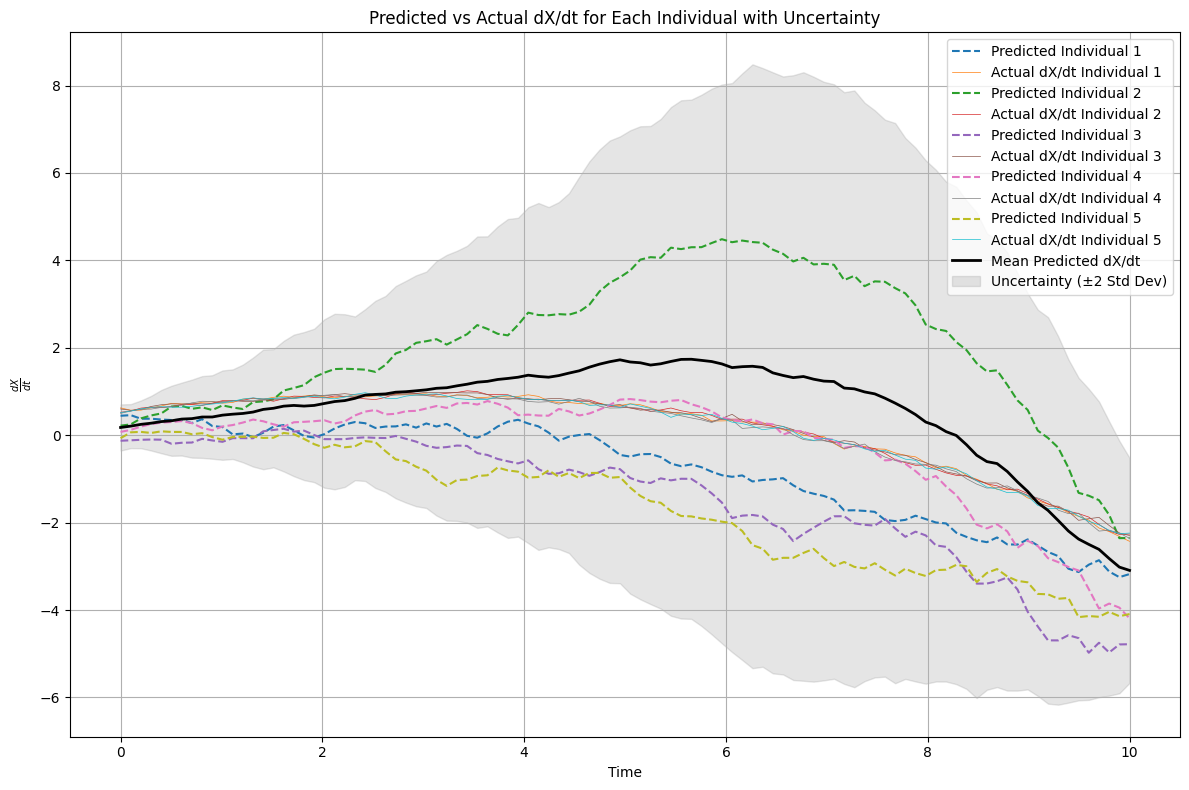

In [34]:
# Prepare to plot
plt.figure(figsize=(12, 8))

# Calculate mean and standard deviation of predicted dX/dt across individuals
mean_predicted = np.mean(dX_dt_predicted_latent, axis=0)  # Shape will be (100,)
std_predicted = np.std(dX_dt_predicted_latent, axis=0)    # Shape will be (100,)

# Now iterate over each individual to plot the predicted and actual dX/dt
for i in range(num_individuals):
    # Plot predicted dX/dt for current individual
    plt.plot(time_points, dX_dt_predicted_latent[i], label=f"Predicted Individual {i + 1}", linestyle='--')

    # Plot actual dX/dt
    actual_dX_dt = np.gradient(results_volume_baseline[i], time_points)
    plt.plot(time_points, actual_dX_dt, label=f"Actual dX/dt Individual {i + 1}", linewidth=0.5)

# Plot the overall mean prediction with uncertainty
plt.plot(time_points, mean_predicted, label="Mean Predicted dX/dt", color='black', linewidth=2)
plt.fill_between(time_points, 
                 mean_predicted - 2*std_predicted, 
                 mean_predicted + 2*std_predicted, 
                 color='gray', alpha=0.2, label='Uncertainty (±2 Std Dev)')

# Customize the plot
plt.xlabel('Time')
plt.ylabel(r'$\frac{dX}{dt}$')
plt.title('Predicted vs Actual dX/dt for Each Individual with Uncertainty')
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

## Predict Cancer Volume

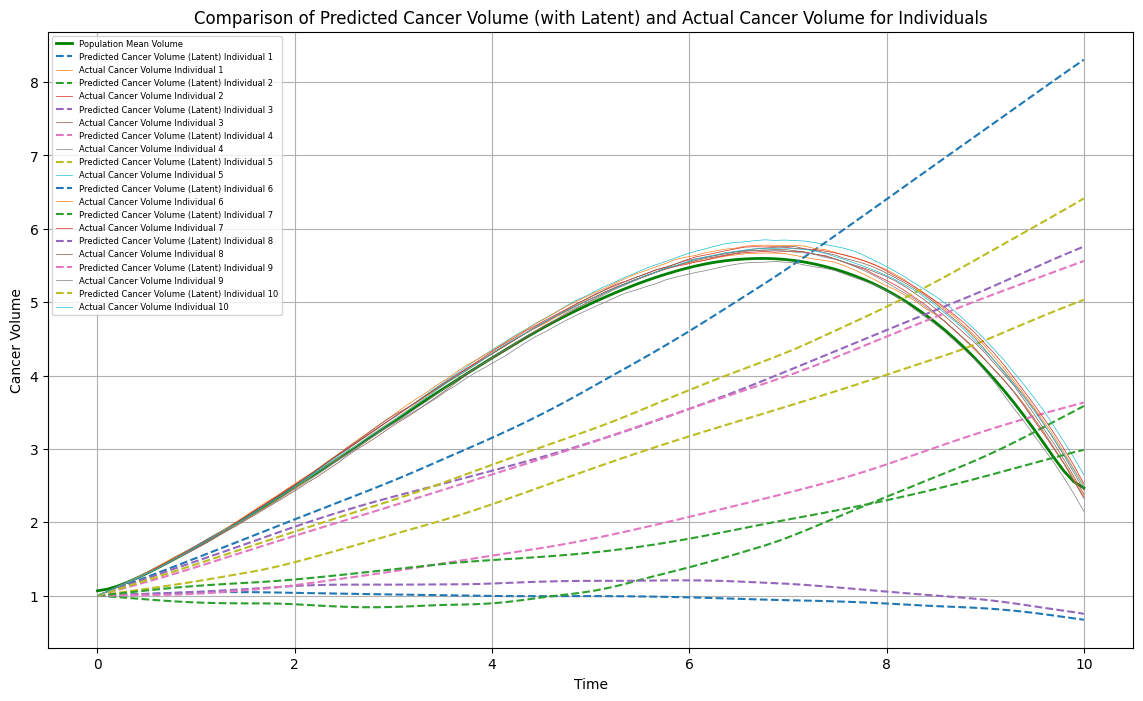

In [8]:
# Predict dX/dt for all individuals using their inferred betas and ground truth latent values
dX_dt_predicted_latent = predict_dX_dt(results_concentration, np.mean(results_volume, axis=0), individual_betas, time_points, latent_coeffs_list)

# Now, predict cancer volumes for all individuals
predicted_cancer_volumes_latent = predict_cancer_volume(dX_dt_predicted_latent, initial_volume=1, time_points=time_points)

# Plotting results for individuals and comparisons between predicted and actual cancer volumes
plt.figure(figsize=(14, 8))

# Plot the mean actual volume
plt.plot(time_points, mean_volume, color='green', linewidth=2, label='Population Mean Volume')

# Plot predictions for all individuals
for i in range(num_individuals):
    plt.plot(time_points, predicted_cancer_volumes_latent[i],
             label=f"Predicted Cancer Volume (Latent) Individual {i + 1}", linestyle='--')
    plt.plot(time_points, results_volume[i],
             label=f"Actual Cancer Volume Individual {i + 1}", linewidth=0.5)  # Plot the actual volume

plt.xlabel("Time")
plt.ylabel("Cancer Volume")
plt.title("Comparison of Predicted Cancer Volume (with Latent) and Actual Cancer Volume for Individuals")
plt.legend(fontsize=6)  # You can specify an exact size
plt.grid()
plt.show()

# ###############Treatment Variable Controlled####################

In [10]:
# Define population parameters (example values; adjust as suited for your model)
k_elim = 0.1  # Elimination rate constant
k_growth = 0.1  # Growth rate constant
k_drug_effect = 0.01  # Drug effect constant
population_params = [k_elim, k_growth, k_drug_effect]
num_individuals = 5

# Define latent variable coefficients
phi = [0.5, 0.02, -0.005] # Example: Coefficients for latent variables,

# Define time points for simulation
time_points = np.linspace(0, 10, 100)  # Time points for the simulation

# Define treatment parameters (example)
treatments = {'dose': 1, 'probability': 0.5}

# Define the pkpd_model and latent_variable functions here...

# Call the generate_pkpd_data function to run the simulation
results_concentration, results_volume, mean_concentration, mean_volume, latent_values = generate_treatment_pkpd_data(num_individuals, population_params, phi, time_points, treatments)

if PLOT_RESULTS:
    # Color map for individual plots
    colors = plt.cm.viridis(np.linspace(0, 1, num_individuals))

    # Plotting the results
    plt.figure(figsize=(12, 18))

    # Plot Latent Variable Q(t)
    plt.subplot(3, 1, 1)
    plt.plot(time_points, latent_values, color='purple', linewidth=2, label='Latent Variable Q(t)')
    plt.title('Latent Variable Q(t) Over Time')
    plt.xlabel('Time')
    plt.ylabel('Q(t)')
    plt.legend()
    plt.grid()

    # Plot Drug Concentration
    plt.subplot(3, 1, 2)
    for i, concentration in enumerate(results_concentration):
        plt.plot(time_points, concentration, color=colors[i], alpha=0.7, label=f'Individual {i+1}')

    plt.plot(time_points, mean_concentration, color='red', linewidth=2, label='Population Mean Concentration')
    plt.title('PK Model: Drug Concentration Over Time')
    plt.xlabel('Time')
    plt.ylabel('Drug Concentration')
    plt.legend()
    plt.grid()

    # Plot Cancer Volume
    plt.subplot(3, 1, 3)
    for i, volume in enumerate(results_volume):
        plt.plot(time_points, volume, color=colors[i], alpha=0.7, label=f'Individual {i+1}')

    plt.plot(time_points, mean_volume, color='green', linewidth=2, label='Population Mean Volume')
    plt.title('PD Model: Cancer Volume Over Time')
    plt.xlabel('Time')
    plt.ylabel('Cancer Volume')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [11]:
# Fit latent dynamics for the concentration of each individual
latent_coeffs_list = []
for i in range(num_individuals):
    latent_coeffs = fit_latent_dynamics(time_points, results_volume[i], degree=2)
    latent_coeffs_list.append(latent_coeffs)
    
# Calculate dX/dt using finite differences for the combined dataset
dX_dt = np.array([np.gradient(results_volume[i], time_points) for i in range(num_individuals)])

# Build the feature library using the combined dataset, now including latent effects
feature_libraries = [build_feature_library_latent(results_concentration[i], results_volume[i], latent_variable(time_points, latent_coeffs_list[i])) for i in range(num_individuals)]

# Initialize beta estimates, which should have the same size as the features used
individual_betas = []
for i in range(num_individuals):
    X_i = results_concentration[i]  # Individual drug concentration
    Z_i = results_volume[i]  # Individual cancer volume
    dX_dt_i = np.gradient(Z_i, time_points)  # Calculate individual dX/dt

    # Build feature library for the individualdX_dt_predicted_a
    feature_library_i = build_feature_library_latent(X_i, Z_i, latent_variable(time_points, latent_coeffs_list[i]))

    # Start with zero estimates for beta
    beta_est = np.zeros(feature_library_i.shape[1])
    beta_individual = fine_tune_individual_dynamics(X_i, dX_dt_i, feature_library_i, beta_est)
    individual_betas.append(beta_individual)


# Predict dX/dt for all individuals including latent influence in prediction
V = np.mean(results_volume, axis=0)  # Average cancer volume across individuals

# Compute predicted dX/dt using the function that incorporates latent effects
dX_dt_predicted = predict_dX_dt_latent(results_concentration, V, individual_betas, time_points, latent_coeffs_list)

# Predict cancer volumes for all individuals based on the predicted dX/dt including latent influences
predicted_cancer_volumes_latent = predict_cancer_volume(dX_dt_predicted, initial_volume=1, time_points=time_points)

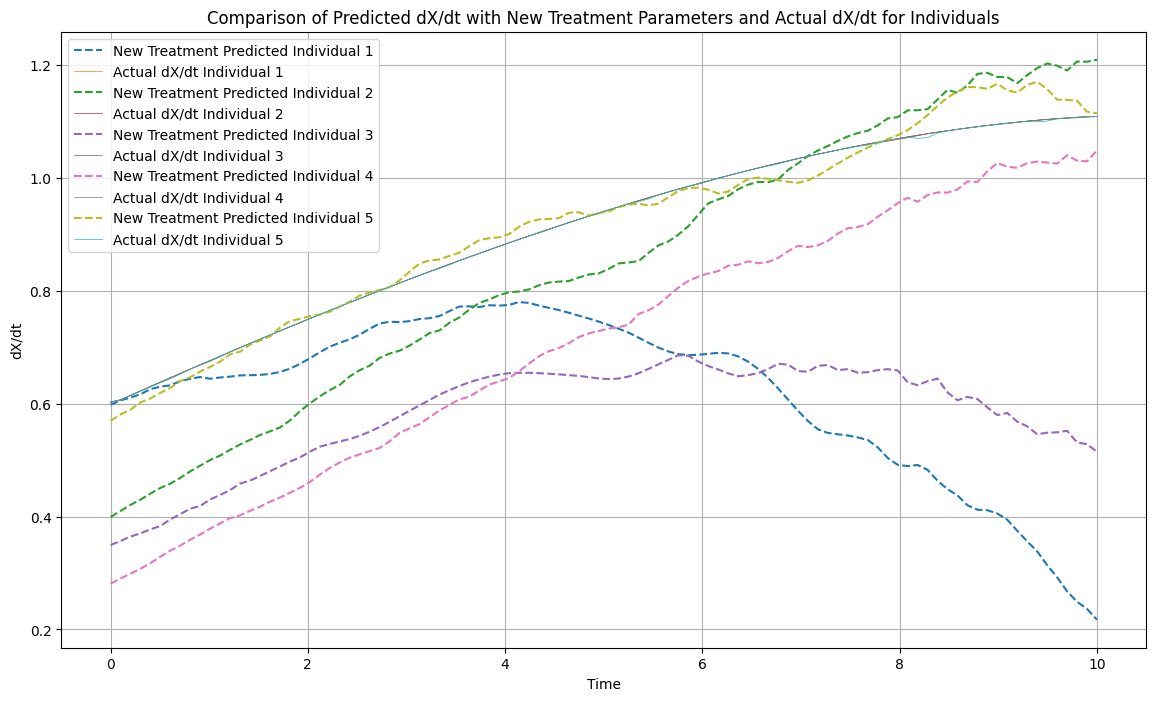

In [12]:
# Define treatment parameters (example)
new_treatment_params = {'dose': 9, 'probability': 0.2}

# Generate new predictions under the modified treatment scenario
results_concentration_new, results_volume_new = generate_new_predictions(num_individuals, population_params, phi, time_points, new_treatment_params)

# Predict dX/dt for all individuals including latent influence in prediction
#V = np.mean(results_volume_new, axis=0)  # Average cancer volume across individuals
#dX_dt_predicted = predict_dX_dt_latent(results_concentration_new, V, individual_betas, time_points, latent_coeffs_list)

# Predict cancer volumes for all individuals with new treatment conditions
predicted_cancer_volumes_new = predict_cancer_volume(dX_dt_predicted, initial_volume=1, time_points=time_points)

# Visualize predicted vs actual dX/dt with new treatment parameters
plt.figure(figsize=(14, 8))

for i in range(num_individuals):
    plt.plot(time_points, dX_dt_predicted[i], label=f"New Treatment Predicted Individual {i + 1}", linestyle='--')
    plt.plot(time_points, np.gradient(results_volume_new[i], time_points), label=f"Actual dX/dt Individual {i + 1}", linewidth=0.5)

plt.xlabel("Time")
plt.ylabel("dX/dt") 
plt.title("Comparison of Predicted dX/dt with New Treatment Parameters and Actual dX/dt for Individuals")
plt.legend()
plt.grid()
plt.show()

## Treatment Settings

In [13]:
treatments = [
    {'dose': 9, 'probability': 0.5},
    {'dose': 3, 'probability': 0.9},
    {'dose': 7, 'probability': 0.7},
]

In [14]:
# Assuming you want to compare MSE for the treatments
actual_volumes = generate_iterative_treatment_new_predictions(num_individuals, population_params, phi, time_points, treatments)

# Calculate individual metrics including latent variables
average_mse_list, std_deviation_mse_list = calculate_average_individual_metrics(treatments, num_individuals, population_params, phi, time_points, actual_volumes, individual_betas, latent_coeffs_list)

# Print average MSE and standard deviation for each individual
for i in range(num_individuals):
    print(f"Individual {i + 1} - Average MSE across treatments: {average_mse_list[i]:.4f}, Standard Deviation: {std_deviation_mse_list[i]:.4f}")

# Optionally calculate overall averages
overall_average_mse = np.mean(average_mse_list)
overall_std_deviation_mse = np.std(average_mse_list)

print(f"Population - Average MSE across treatments: {overall_average_mse:.4f}, Overall Standard Deviation: {overall_std_deviation_mse:.4f}")

Individual 1 - Average MSE across treatments: 8.2158, Standard Deviation: 1.4188
Individual 2 - Average MSE across treatments: 9.6628, Standard Deviation: 1.7649
Individual 3 - Average MSE across treatments: 10.4999, Standard Deviation: 2.2581
Individual 4 - Average MSE across treatments: 10.4070, Standard Deviation: 2.1402
Individual 5 - Average MSE across treatments: 7.8480, Standard Deviation: 1.3192
Population - Average MSE across treatments: 9.3267, Overall Standard Deviation: 1.1025


In [15]:
# Assuming you want to compare MSE for the first treatment
actual_volumes = generate_iterative_treatment_new_predictions(num_individuals, population_params, phi, time_points, treatments)

# Calculate average MSE and standard deviation for each treatment
average_mse_list, std_deviation_mse_list = calculate_average_treatment_mse(treatments, num_individuals, population_params, phi, time_points, actual_volumes, individual_betas, latent_coeffs_list)

# Print the average MSE and standard deviation for each treatment
for i, (mse, std) in enumerate(zip(average_mse_list, std_deviation_mse_list)):
    print(f"Average MSE for Treatment {i + 1} (Dose: {treatments[i]['dose']}, Probability: {treatments[i]['probability']}): {mse:.4f}, Standard Deviation: {std:.4f}")

Average MSE for Treatment 1 (Dose: 9, Probability: 0.5): 11.2230, Standard Deviation: 1.7993
Average MSE for Treatment 2 (Dose: 3, Probability: 0.9): 9.1177, Standard Deviation: 1.2638
Average MSE for Treatment 3 (Dose: 7, Probability: 0.7): 7.0268, Standard Deviation: 1.9399


# NO LATENT Approach 

In [21]:
from baselineINSITE import *

# Example Parameters
population_parameters = (0.1, 0.1, 0.01)  # k_elim, k_growth, k_drug_effect
time_points = np.linspace(0, 10, 100)  # Time points for the simulation

# Latent variable polynomial coefficients (change degree as needed)
phi = [0.5, 0.2, -0.05]  # Example coefficients for Q(t) = 0.5 + 0.2*t - 0.05*t^2 (quadratic)

# Generate Data
num_individuals = 5

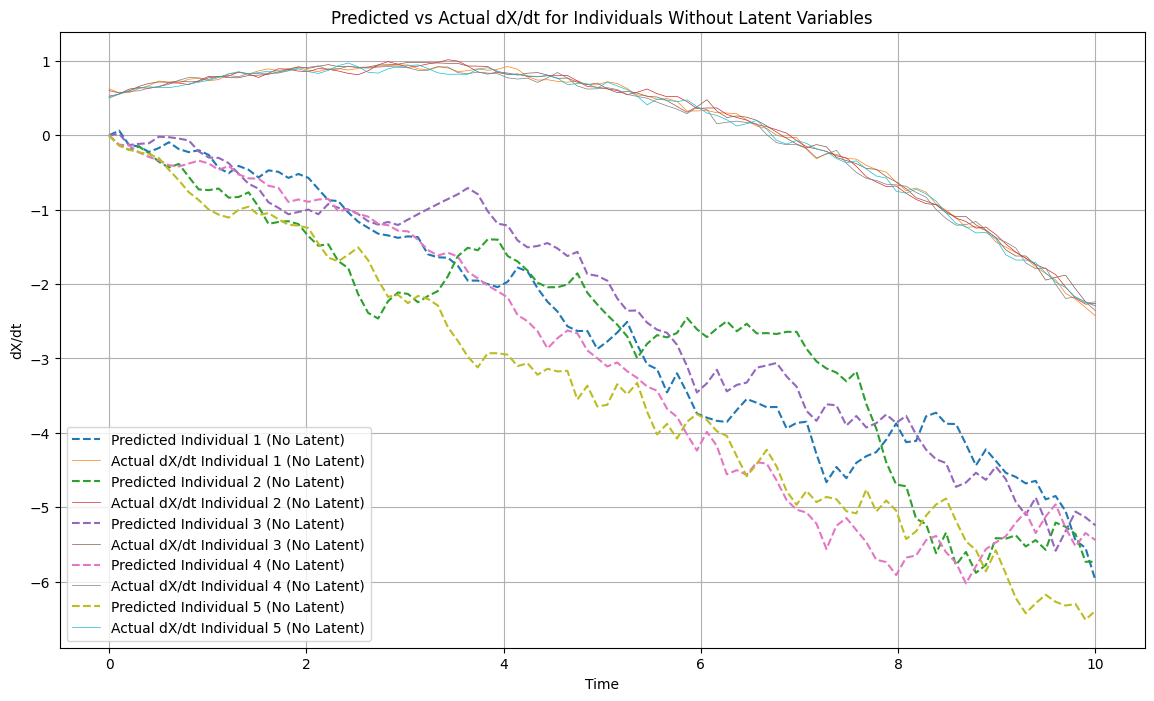

In [22]:
# Calculate dX/dt for each individual
individual_dX_dt = [np.gradient(results_volume_baseline[i], time_points) for i in range(num_individuals)]

# Build the feature library without latent variables
feature_libraries_no_latent = [build_feature_library_no_latent(results_concentration_baseline[i]) for i in range(num_individuals)]

# Fit the population-level ODE without latent influence
beta_est_no_latent = fit_population_dynamics_no_latent(time_points, individual_dX_dt[0], feature_libraries_no_latent[0])

# Fine-tune for individual-specific dynamics without latent variables
individual_betas_no_latent = []
for i in range(num_individuals):
    beta_individual_no_latent = fine_tune_individual_dynamics(results_concentration_baseline[i], individual_dX_dt[i], feature_libraries_no_latent[i], beta_est_no_latent)
    individual_betas_no_latent.append(beta_individual_no_latent)

# Predict dX/dt using inferred coefficients for each individual without latent influence
dX_dt_predicted_no_latent = predict_dX_dt_no_latent(results_concentration_baseline, np.zeros(time_points.shape), individual_betas_no_latent, time_points)
# Generate dX/dt predictions for the population level without latent influence
dX_dt_predicted_no_latent_mean = np.mean(dX_dt_predicted_no_latent, axis=0)


# Plotting results for individuals and predictions without latent influence
plt.figure(figsize=(14, 8))

# Comparison of predicted and actual dX/dt for individuals without latent influence
for i in range(num_individuals):
    plt.plot(time_points, dX_dt_predicted_no_latent[i], label=f"Predicted Individual {i + 1} (No Latent)", linestyle='--')
    plt.plot(time_points, individual_dX_dt[i], label=f"Actual dX/dt Individual {i + 1} (No Latent)", linewidth=0.5)

plt.xlabel("Time")
plt.ylabel("dX/dt")
plt.title("Predicted vs Actual dX/dt for Individuals Without Latent Variables")
plt.legend()
plt.grid()
plt.show()

## Average MSE : X runs : No Latent

In [23]:
# Settings for the experiment
num_runs = 5  # Number of simulations
mse_values = []

for run in range(num_runs):
    # Generate Data
    results_concentration, results_volume, _, _, _ = generate_baseline_pkpd_data(num_individuals, population_parameters, phi, time_points)

    # Calculate dX/dt for each individual
    individual_dX_dt = [np.gradient(results_volume[i], time_points) for i in range(num_individuals)]

    # Build the feature library without latent variables
    feature_libraries_no_latent = [build_feature_library_no_latent(results_concentration[i]) for i in range(num_individuals)]

    # Initialize beta estimates
    individual_betas_no_latent = []

    for i in range(num_individuals):
        X_i = results_concentration[i]  # Individual drug concentration

        # Build feature library for the individual
        feature_library_i = build_feature_library_no_latent(X_i)

        # Start with zero estimates for beta
        beta_est_no_latent = np.zeros(feature_library_i.shape[1])
        beta_individual_no_latent = fine_tune_individual_dynamics(results_concentration[i], individual_dX_dt[i], feature_libraries_no_latent[i], beta_est_no_latent)
        individual_betas_no_latent.append(beta_individual_no_latent)

    # Predict dX/dt using inferred coefficients for each individual without latent influence
    V = np.mean(results_volume, axis=0)  # Average cancer volume across individuals
    dX_dt_predicted_no_latent = predict_dX_dt_no_latent(results_concentration, V, individual_betas_no_latent, time_points)

    # Calculate MSE for this run
    mse_run = []
    for i in range(num_individuals):
        mse = calculate_mse(individual_dX_dt[i], dX_dt_predicted_no_latent[i])
        mse_run.append(mse)

    # Append the run's MSE values to the overall list
    mse_values.append(mse_run)

# Convert to array for further analysis
mse_values = np.array(mse_values)

# Calculate average MSE and standard deviation across runs for each individual
average_mse = np.mean(mse_values, axis=0)
std_deviation_mse = np.std(mse_values, axis=0)

# Print the results
for i in range(num_individuals):
    print(f"Individual {i + 1} - Average MSE: {average_mse[i]:.4f}, Standard Deviation: {std_deviation_mse[i]:.4f}")

# Calculate and print overall averages for the population
overall_average_mse = np.mean(average_mse)
overall_std_deviation_mse = np.mean(std_deviation_mse)

print(f"Overall Average MSE across all individuals: {overall_average_mse:.4f}, Overall Standard Deviation: {overall_std_deviation_mse:.4f}")

Individual 1 - Average MSE: 11.9996, Standard Deviation: 3.6342
Individual 2 - Average MSE: 9.7669, Standard Deviation: 2.3469
Individual 3 - Average MSE: 11.6471, Standard Deviation: 2.1961
Individual 4 - Average MSE: 11.9127, Standard Deviation: 3.7456
Individual 5 - Average MSE: 14.3103, Standard Deviation: 1.9113
Overall Average MSE across all individuals: 11.9273, Overall Standard Deviation: 2.7668


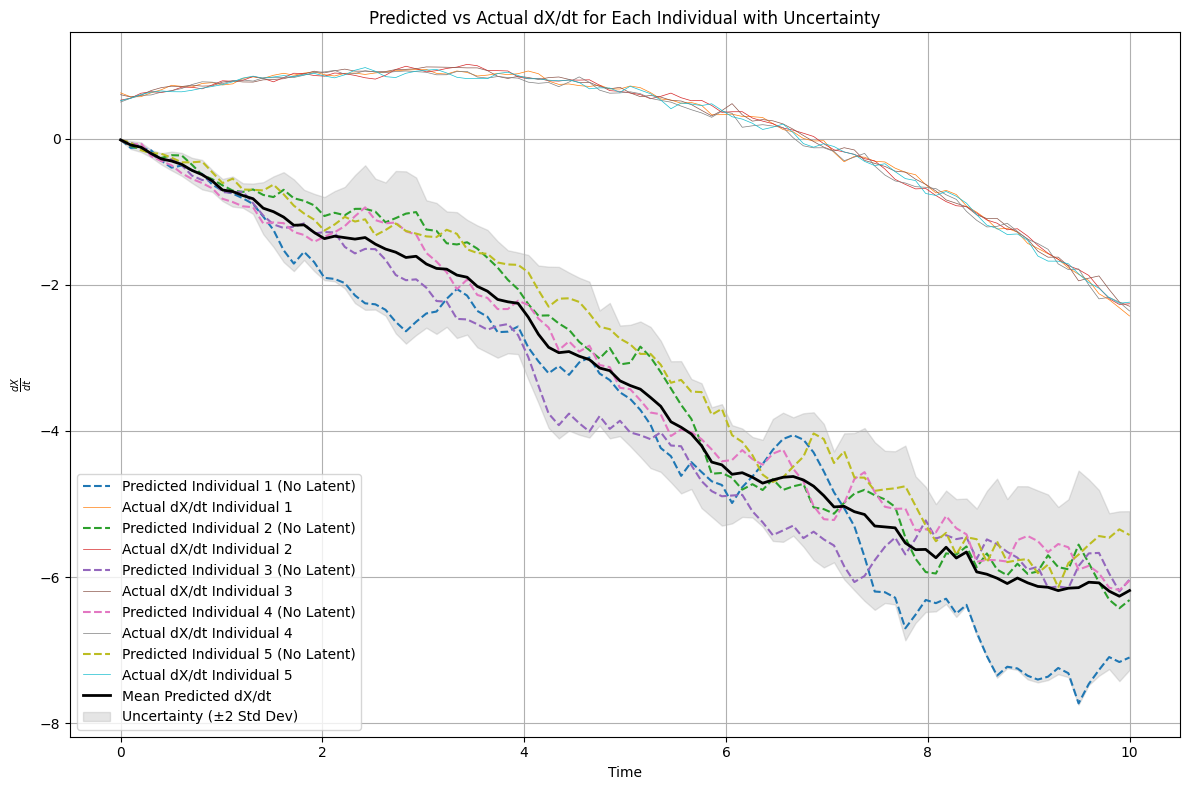

In [33]:
# Prepare to plot
plt.figure(figsize=(12, 8))

# Calculate mean and standard deviation of predicted dX/dt across individuals
mean_predicted_no_latent = np.mean(dX_dt_predicted_no_latent, axis=0)  # Shape will be (100,)
std_predicted_no_latent = np.std(dX_dt_predicted_no_latent, axis=0)    # Shape will be (100,)

# Now iterate over each individual to plot the predicted and actual dX/dt
for i in range(num_individuals):

    # Plot actual dX/dt
    actual_dX_dt = np.gradient(results_volume_baseline[i], time_points)
    plt.plot(time_points, dX_dt_predicted_no_latent[i], label=f"Predicted Individual {i + 1} (No Latent)", linestyle='--')
    plt.plot(time_points, actual_dX_dt, label=f"Actual dX/dt Individual {i + 1}", linewidth=0.5)

# Plot the overall mean prediction with uncertainty
plt.plot(time_points, mean_predicted_no_latent, label="Mean Predicted dX/dt", color='black', linewidth=2)
plt.fill_between(time_points, 
                 mean_predicted_no_latent - 2*std_predicted_no_latent, 
                 mean_predicted_no_latent + 2*std_predicted_no_latent, 
                 color='gray', alpha=0.2, label='Uncertainty (±2 Std Dev)')

# Customize the plot
plt.xlabel('Time')
plt.ylabel(r'$\frac{dX}{dt}$')
plt.title('Predicted vs Actual dX/dt for Each Individual with Uncertainty')
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

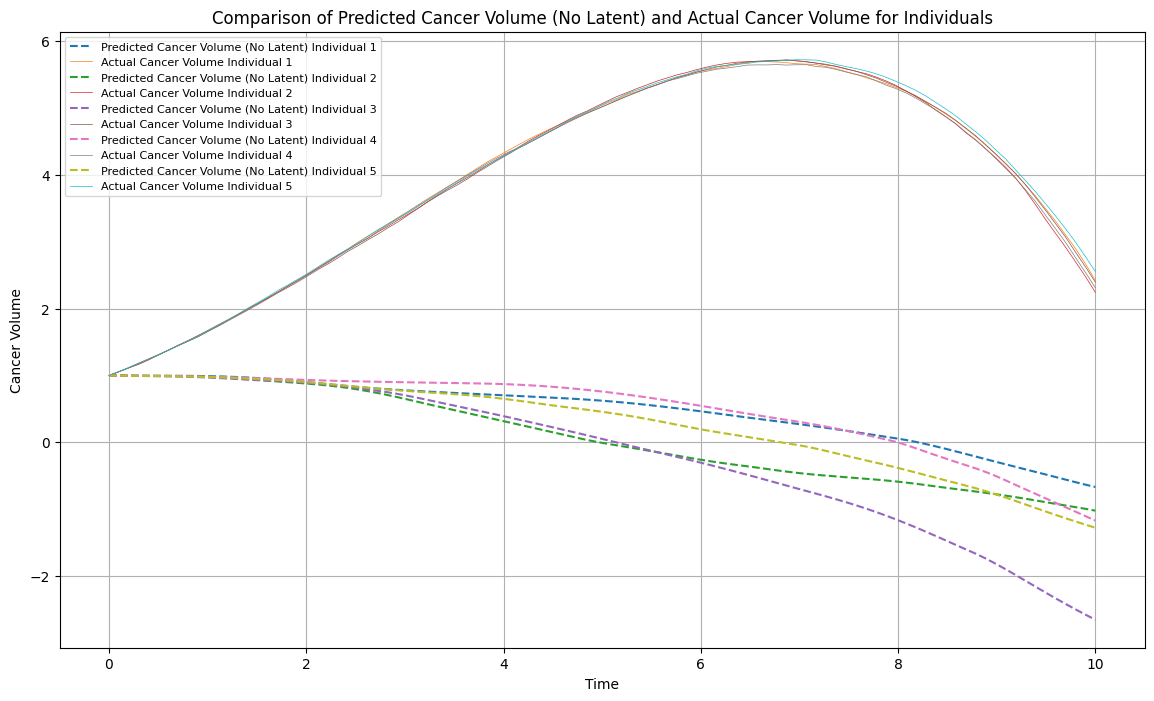

In [25]:
# Predict cancer volumes using the predicted dX/dt without latent effects
predicted_cancer_volumes_no_latent = predict_cancer_volume_no_latent(dX_dt_predicted_no_latent, 1, time_points)
# Plotting results for individuals and comparisons between predicted and actual cancer volumes without latent influence
plt.figure(figsize=(14, 8))

for i in range(num_individuals):
    plt.plot(time_points, predicted_cancer_volumes_no_latent[i], 
             label=f"Predicted Cancer Volume (No Latent) Individual {i + 1}", linestyle='--')
    plt.plot(time_points, results_volume[i], 
             label=f"Actual Cancer Volume Individual {i + 1}", linewidth=0.5)

plt.xlabel("Time")
plt.ylabel("Cancer Volume")
plt.title("Comparison of Predicted Cancer Volume (No Latent) and Actual Cancer Volume for Individuals")
plt.legend(fontsize=8)  # You can specify an exact size
plt.grid()
plt.show()

# ###############Treatment Variable Controlled####################

In [26]:
# Define population parameters (example values; adjust as suited for your model)
k_elim = 0.1  # Elimination rate constant
k_growth = 0.1  # Growth rate constant
k_drug_effect = 0.01  # Drug effect constant
population_params = [k_elim, k_growth, k_drug_effect]
num_individuals = 5

# Define latent variable coefficients
phi = [0.5, 0.02, -0.005] # Example: Coefficients for latent variables,

# Define time points for simulation
time_points = np.linspace(0, 10, 100)  # Time points for the simulation

# Define treatment parameters (example)
treatments = {'dose': 9, 'probability': 0.5}

# Define the pkpd_model and latent_variable functions here...

# Call the generate_pkpd_data function to run the simulation


In [27]:
# Call the generate_pkpd_data function to run the simulation
results_concentration, results_volume, mean_concentration, mean_volume, latent_values = generate_treatment_pkpd_data(num_individuals, population_params, phi, time_points, treatments)

# Calculate dX/dt using finite differences for the combined dataset
dX_dt = np.array([np.gradient(results_volume[i], time_points) for i in range(num_individuals)])

# Build the feature library using the combined dataset, now including latent effects
feature_libraries = [build_feature_library_no_latent(results_concentration[i]) for i in range(num_individuals)]

# Initialize beta estimates, which should have the same size as the features used
individual_betas_no_latent = []
for i in range(num_individuals):
    X_i = results_concentration[i]  # Individual drug concentration
    Z_i = results_volume[i]  # Individual cancer volume
    dX_dt_i = np.gradient(Z_i, time_points)  # Calculate individual dX/dt

    # Build feature library for the individualdX_dt_predicted_a
    feature_library_i = build_feature_library_no_latent(X_i)

    # Start with zero estimates for beta
    beta_est = np.zeros(feature_library_i.shape[1])
    beta_individual_no_latent = fine_tune_individual_dynamics(X_i, dX_dt_i, feature_library_i, beta_est)
    individual_betas_no_latent.append(beta_individual_no_latent)


# Predict dX/dt for all individuals including latent influence in prediction
V = np.mean(results_volume, axis=0)  # Average cancer volume across individuals

# Compute predicted dX/dt using the function that incorporates latent effects
dX_dt_predicted_no_latent = predict_dX_dt_no_latent(results_concentration, V, individual_betas_no_latent, time_points)

# Predict cancer volumes for all individuals based on the predicted dX/dt including latent influences
predicted_cancer_volumes_latent = predict_cancer_volume_no_latent(dX_dt_predicted_no_latent, initial_volume=1, time_points=time_points)

## No Latent Framework Average Treatment Analysis

In [28]:
treatments = [
    {'dose': 1, 'probability': 0.4},
    {'dose': 7, 'probability': 0.5},
    {'dose': 8, 'probability': 0.1},
]

In [29]:
# Assuming you want to compare MSE for the treatments
actual_volumes = generate_iterative_treatment_new_predictions(num_individuals, population_params, phi, time_points, treatments)

# Calculate individual metrics including latent variables
average_mse_list, std_deviation_mse_list = calculate_average_individual_metrics(treatments, num_individuals, population_params, phi, time_points, actual_volumes, individual_betas_no_latent, latent_coeffs_list =None,latent=False)

# Print average MSE and standard deviation for each individual
for i in range(num_individuals):
    print(f"Individual {i + 1} - Average MSE across treatments: {average_mse_list[i]:.4f}, Standard Deviation: {std_deviation_mse_list[i]:.4f}")

# Optionally calculate overall averages
overall_average_mse = np.mean(average_mse_list)
overall_std_deviation_mse = np.std(average_mse_list)

print(f"Population - Average MSE across treatments: {overall_average_mse:.4f}, Overall Standard Deviation: {overall_std_deviation_mse:.4f}")

Individual 1 - Average MSE across treatments: 17.5269, Standard Deviation: 3.1305
Individual 2 - Average MSE across treatments: 17.7550, Standard Deviation: 3.2866
Individual 3 - Average MSE across treatments: 17.8981, Standard Deviation: 2.9552
Individual 4 - Average MSE across treatments: 17.5969, Standard Deviation: 3.7815
Individual 5 - Average MSE across treatments: 18.2040, Standard Deviation: 3.1650
Population - Average MSE across treatments: 17.7962, Overall Standard Deviation: 0.2411


In [30]:
# Assuming you want to compare MSE for the treatments
actual_volumes_no_latent = generate_iterative_treatment_new_predictions(num_individuals, population_params, phi, time_points, treatments)

# Calculate average metrics for each treatment
average_mse_list, std_deviation_mse_list = calculate_average_treatment_mse(treatments, num_individuals, population_params, phi, time_points, actual_volumes_no_latent, individual_betas_no_latent, latent_coeffs_list=None, latent=False)

# Print the average MSE and standard deviation for each treatment
for i, (mse, std) in enumerate(zip(average_mse_list, std_deviation_mse_list)):
    print(f"Average MSE for Treatment {i + 1} (Dose: {treatments[i]['dose']}, Probability: {treatments[i]['probability']}): {mse:.4f}, Standard Deviation: {std:.4f}")

Average MSE for Treatment 1 (Dose: 1, Probability: 0.4): 18.8587, Standard Deviation: 0.6123
Average MSE for Treatment 2 (Dose: 7, Probability: 0.5): 13.6884, Standard Deviation: 0.4740
Average MSE for Treatment 3 (Dose: 8, Probability: 0.1): 21.3920, Standard Deviation: 0.2331


## Population-level Analysis

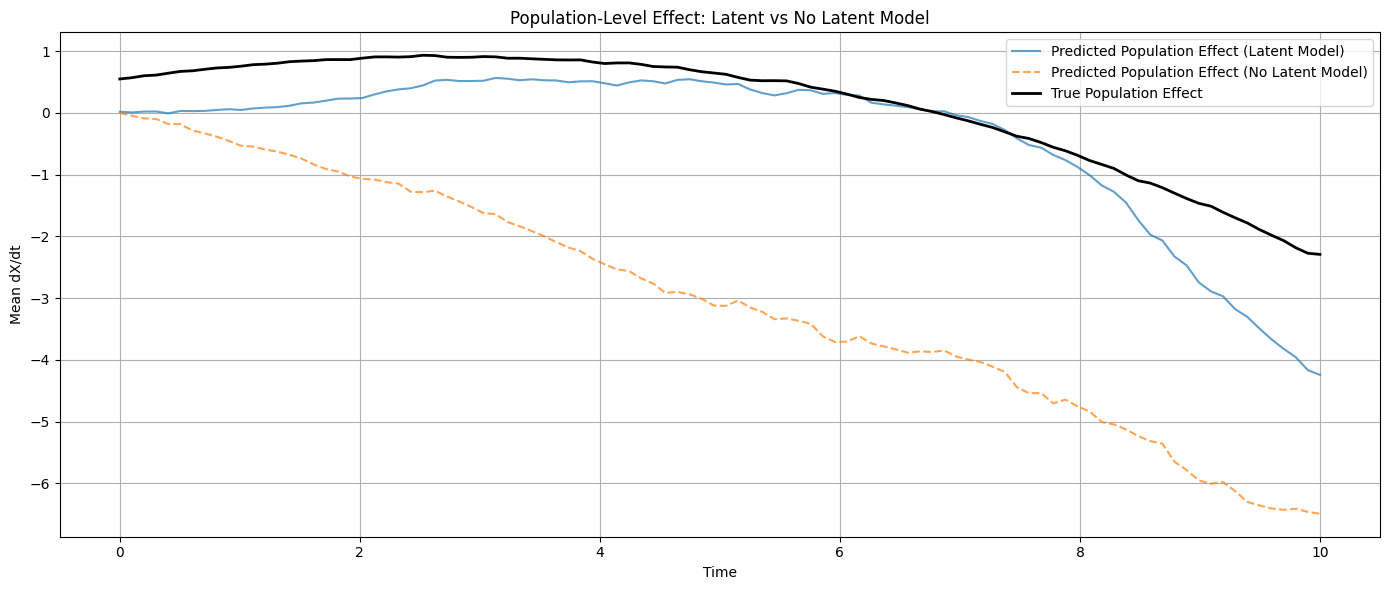

In [14]:
# Plot: Population-level comparison for latent vs. no latent model
plt.figure(figsize=(14, 6))

# Plot predictions with latent model
plt.plot(time_points, dX_dt_predicted_with_latent_mean, label='Predicted Population Effect (Latent Model)', alpha=0.7)

# Plot predictions with direct model (no latent variables)
plt.plot(time_points, dX_dt_predicted_no_latent_mean, linestyle='--', label='Predicted Population Effect (No Latent Model)', alpha=0.7)

# Plot ground truth
plt.plot(time_points, dX_dt_ground_truth, label='True Population Effect', color='black', linewidth=2)

# Title and labels
plt.title("Population-Level Effect: Latent vs No Latent Model")
plt.xlabel("Time")
plt.ylabel("Mean dX/dt")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()